# Example usage of the TaylorAnalysis

This is an example for the usage of the TaylorAnalysis tool. 
It is designed to work on a very essential level in order to leave maximal flexibility to the user. 

Therefore some usecases and methods are shown how one may apply TaylorAnalysis.

In [1]:
import torch
import matplotlib.pyplot as plt
import itertools

from torch import nn
from helpers import gen_data, Mlp, plot_data, get_feature_combis
from tayloranalysis.model_extension import extend_model

### Setup Data

Create a two dimensional dataset with three classes which we want du discriminate against each other.

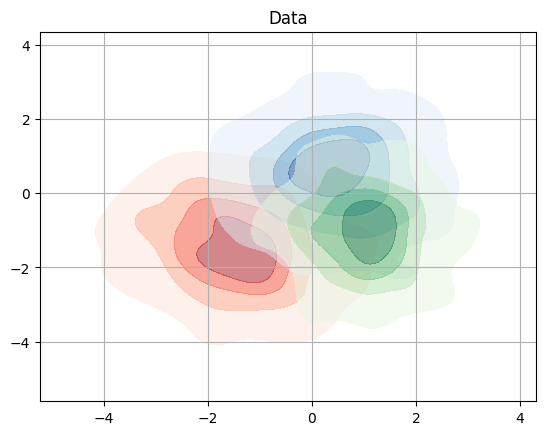

In [2]:
names = ["x1", "x2"]
x_train, y_train = gen_data(400)
x_test, y_test = gen_data(400)
plot_data(x_train, y_train)  

Split in train and test dataset and one-hot-encode the target labels for the training.

In [3]:
x_test, y_test, x_train, y_train = map(
    lambda x: torch.tensor(x).float(),
    (x_test, y_test, x_train, y_train),
)

# one hot encode y train
y_train = nn.functional.one_hot(y_train.to(torch.int64), 3).float()

### Setup Model and TaylorAnalysis tool

Now we will have a look at two ways on how to add the TaylorAnalysis functionality to a `torch` model.

First step is to define a reduce function in order to summarize the taylorcoefficients computed based on the points in the dataset.
The default is set to the identity function, i.e. no reduction is applied.
We will demonstrate this with a simple mean function.

Note: The reduce function also specifies the datatype which is written into the output dict!

In [4]:
def reduce(x: torch.Tensor):
    return torch.mean(x).cpu().detach().numpy()

Now extend an exemplary `Mlp` with the TaylorAnalysis functionality. Here we can either use the `Mlp` class as an input for the `extend_model` function...

In [5]:
WrappedMlp = extend_model(Mlp)
model = WrappedMlp(input_neurons=2, hidden_neurons=20, output_neurons=3, hiddenlayers=3)

... or an already initialized instance of `Mlp` which can be extendet by the Tayloranalysis functionality.

In [6]:
#model = Mlp(input_neurons=2, hidden_neurons=10, output_neurons=3, hiddenlayers=2)
#model = extend_model(model)

Now setup training parameters and move everything to cuda if available.

In [7]:
optim = torch.optim.Adam(model.parameters(), lr=0.001)
crit = nn.CrossEntropyLoss()

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
x_train = x_train.to(device)
y_train = y_train.to(device)
model.to(device)

Mlp(
  (mlplayers): ModuleList(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1-4): 4 x Linear(in_features=20, out_features=20, bias=True)
    (5): Linear(in_features=20, out_features=3, bias=True)
  )
)

Determine the taylorcoefficients to compute. 
These must be a list of tuples!
For more numerious combinations you should use itertools, as exemplary shown!

In [8]:
combinations = [(0,), (1,)]  # 1st order taylor coefficients
combinations += [
    i for i in itertools.permutations([0, 1], 2)
]  # 2nd order taylor coefficients
combinations += [(0, 1, 1)]  # exemplary 3rd order taylor coefficient
combinations

[(0,), (1,), (0, 1), (1, 0), (0, 1, 1)]

This means we will compute:
- First order TCs of feature nr. 0 and feature nr. 1
- Second order TCs of feature combinations: nr. 0 and 1, as well as nr. 1 and 0
- Third order TC of feature combinations: nr. 0, 1, 1

### Training

Now start the training and write out taylorcoefficients after each epoch.

Have a look at the advanced arguments you can pass to the `get_tcs` function. Note `tctensor` refers to the tensor based on which the taylorcoefficients are computed.

```
Function to handle multiple indices and return the taylorcoefficients as a dictionary: to be used by the user.

Args:
    forward_kwargs_tctensor_key (str): Key to input tensor in forward_kwargs. Based on this tensor the taylorcoefficients are computed.
    forward_kwargs (Union[None, Dict[str, Any]]): Dictionary with forward arguments
    tc_idx_list (List[Tuple[int, ...]]): List of indices for which the taylorcoefficients should be computed based on the tensor selected by forward_kwargs_tctensor_key (and additional_idx_to_tctensor).
    selected_output_node (Int, optional): Node selection for evaluation. Defaults to None.
    eval_max_output_node_only (Bool, optional): If True, only the node with the highest value is selected. Defaults to True.
    reduce_func (Callable, optional): Function to reduce the taylorcoefficients. Defaults to identity.
    tctensor_features_axis (int, optional): Dimension containing features in tctensor given in forward_kwargs. Defaults to -1.
    additional_idx_to_tctensor (int, optional): Index of the tctensor if forward_kwargs[forward_kwargs_tctensor_key] is a list. Defaults to None.
    selected_model_output_idx (int, optional): Index of the model output if its output is a sequence. Defaults to 0.
Raises:
    ValueError: tc_idx_list must be a List of tuples!

Returns:
    Dict: Dictionary with taylorcoefficients. Values are set by the user within the reduce function. Keys are the indices (tuple).

```

`tctensor` refers to the tensor based on which the taylorcoefficients are computed. 









In [9]:
tcs_training = []
x_train.requires_grad = True
for epoch in range(250):
    optim.zero_grad()
    pred = model(x_train)
    loss = crit(pred, y_train)
    loss.backward()
    optim.step()

    if epoch % 10 == 0:
        print("Epoch {}: Loss: {:.3f}".format(epoch + 1, loss))

    tc_dict = model.get_tc(
        "x",
        forward_kwargs={"x": x_test.to(device)},
        tc_idx_list=combinations,
        reduce_func=reduce)
    # here we directly unpack the dictionary values into a list
    tcs_training.append(list(tc_dict.values()))

Epoch 1: Loss: 1.096
Epoch 11: Loss: 1.079
Epoch 21: Loss: 1.049
Epoch 31: Loss: 1.002
Epoch 41: Loss: 0.948
Epoch 51: Loss: 0.904
Epoch 61: Loss: 0.875
Epoch 71: Loss: 0.855
Epoch 81: Loss: 0.839
Epoch 91: Loss: 0.825
Epoch 101: Loss: 0.815
Epoch 111: Loss: 0.806
Epoch 121: Loss: 0.799
Epoch 131: Loss: 0.792
Epoch 141: Loss: 0.786
Epoch 151: Loss: 0.781
Epoch 161: Loss: 0.777
Epoch 171: Loss: 0.773
Epoch 181: Loss: 0.769
Epoch 191: Loss: 0.766
Epoch 201: Loss: 0.764
Epoch 211: Loss: 0.762
Epoch 221: Loss: 0.760
Epoch 231: Loss: 0.758
Epoch 241: Loss: 0.756


### Evaluation

Get the combinations with feature names instead of feature numbers for plotting. Have a look at the `get_feature_combis` function!

In [10]:
labels = get_feature_combis(names, combinations)
labels = [",".join(label) for label in labels]
labels

['x1', 'x2', 'x1,x2', 'x2,x1', 'x1,x2,x2']

Have a look at the development of the taylorcoefficients during the training!

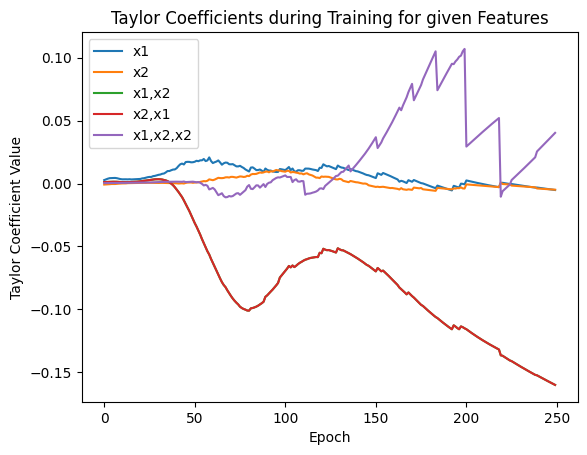

In [11]:
plt.title("Taylor Coefficients during Training for given Features")
plt.plot(tcs_training, label=labels)
plt.xlabel("Epoch")
plt.ylabel("Taylor Coefficient Value")
plt.legend()
plt.show()

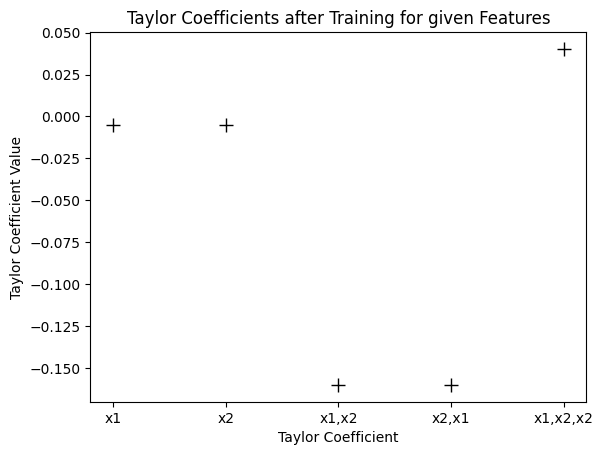

In [12]:
# get a set of target taylor coefficients after training
model.cpu()
tc_dict = model.get_tc(
    "x",
    forward_kwargs={"x": x_test},
    tc_idx_list=combinations,
    reduce_func=reduce)

# plot tcs after training
plt.title("Taylor Coefficients after Training for given Features")
plt.plot(labels, list(tc_dict.values()), "+", color="black", markersize=10)
plt.xlabel("Taylor Coefficient")
plt.ylabel("Taylor Coefficient Value")
plt.show()